<a href="https://colab.research.google.com/github/RummanAli/Rum_69/blob/master/HEPAE_4D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import fastai
import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import pandas as pd

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader



from fastai import basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai
import pickle
import matplotlib.pyplot as plt
import numpy as np


In [0]:
class AE_3D_200(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 100)
        self.en3 = nn.Linear(100, 50)
        self.en4 = nn.Linear(50, 3)
        self.de1 = nn.Linear(3, 50)
        self.de2 = nn.Linear(50, 100)
        self.de3 = nn.Linear(100, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-100-50-3-50-100-200-out'



In [0]:
train = pd.read_pickle('/content/all_jets_train_4D_100_percent.pkl')
test = pd.read_pickle('/content/all_jets_test_4D_100_percent.pkl')

In [0]:
loss_func = nn.MSELoss()
model = AE_3D_200()
n_features = len(train.loc[0])
print(n_features)


4


In [0]:
test.shape

(27945, 4)

In [0]:
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values).float(), torch.tensor(train_y.values).float())
valid_ds = TensorDataset(torch.tensor(test_x.values).float(), torch.tensor(test_y.values).float())

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

db = basic_data.DataBunch(train_dl, valid_dl)


In [0]:
bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd = 1e-6

In [0]:
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

In [0]:
learn.load('/content/AE_3D_200_no1cycle_trainforever')

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7faa116856a0>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7faa116916a0>;

Test: None, model=AE_3D_200(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=100, bias=True)
  (en3): Linear(in_features=100, out_features=50, bias=True)
  (en4): Linear(in_features=50, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=MSELoss(), metrics=[], true_wd=True, bn_wd=False, wd=1e-06, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, 

In [0]:
learn.validate()

[0.5058878]

In [0]:
idxs = (0, 100000)

In [0]:
idxs[1]

100000

In [0]:
data = torch.tensor(test_x[idxs[0]:idxs[1]].values).float()

In [0]:
data.shape

torch.Size([27945, 4])

In [0]:
train_mean.values

array([8.941357e+03, 6.445868e+04, 1.691170e-03, 4.350001e-02])

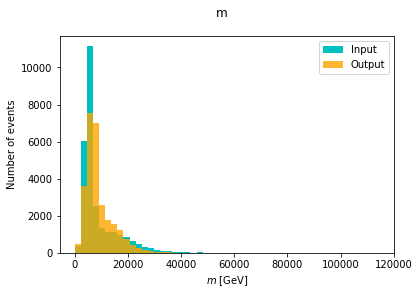

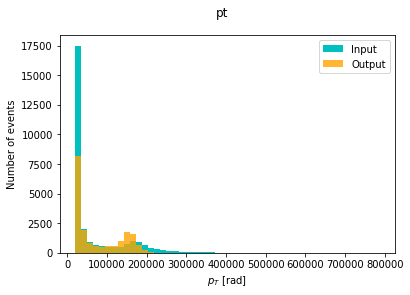

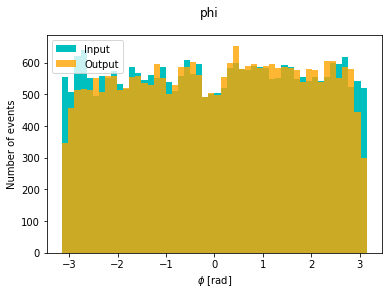

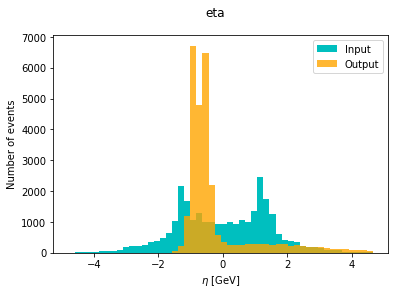

In [0]:

plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$m$', r'$p_T$', r'$\phi$', r'$\eta$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values).float()
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    #ms.sciy()
    # plt.yscale('log')
    plt.legend()
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)

In [0]:
plo=np.divide(np.subtract(data,pred),data)

In [0]:
plo.shape

torch.Size([27945, 4])

In [0]:
data[0]

tensor([ 4.9837e+03,  2.3798e+04,  1.9622e+00, -5.9532e-02],
       dtype=torch.float64)

In [0]:
plo[0]

tensor([ -0.1926,   0.1963,   0.0322, -11.5400], dtype=torch.float64)

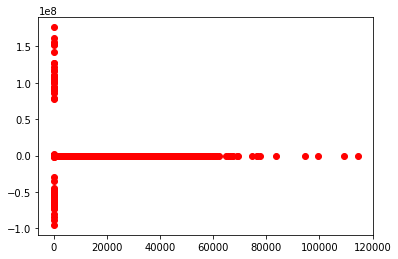

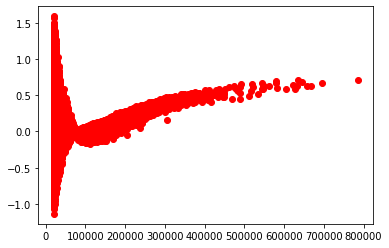

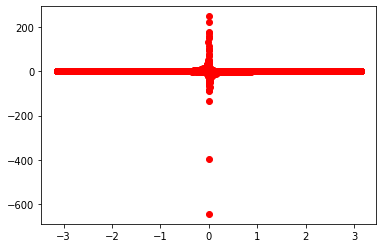

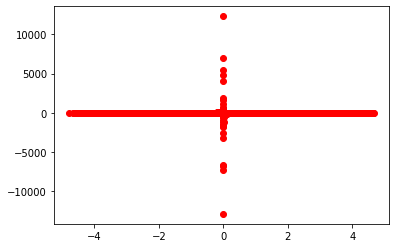

In [0]:
for i in np.arange(4):
  plt.figure(i)
  plt.plot(data[:,i],plo[:,i],'ro')